In [1]:
import Pkg
#Pkg.add("StatsBase")
#Pkg.add("Distributions")
#Pkg.add("GraphPlot")
#Pkg.add("Plots")
#Pkg.add("GraphRecipes")
#Pkg.add("NetworkLayout")
#Pkg.add("GeometryTypes")
#Pkg.add("PaddedViews")
#Pkg.add("Cairo")
#Pkg.add("Compose")
#Pkg.add("Plots")
#Pkg.add("PyPlot")
using StatsBase
using Random
using Distributions
using LinearAlgebra
using LightGraphs
#using LightGraphs: smallgraph
using GraphPlot
#using GraphRecipes, Plots
#using NetworkLayout:SFDP
#using GeometryTypes
using PaddedViews
using Cairo, Compose
using Plots
ENV["PYTHON"] = raw"C:\Python38\python.exe" 
Pkg.build("PyCall")
using PyCall
pyplot() #change backend

#Pkg.add("JuMP")
#Pkg.add("GLPK")
using JuMP
using GLPK


   Building Conda ─→ `C:\Users\Bastiiii\.julia\packages\Conda\x5ml4\deps\build.log`
   Building PyCall → `C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\deps\build.log`


In [2]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [3]:
"""
ForSample function https://github.com/JuliaStats/StatsBase.jl/blob/08d4b77a4b42ef8cadb67b98da65e7fbd9959e0b/src/sampling.jl#L445-L456

In our code, we use a simple sample fucntion, which has a stucture below
## sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false) ##

For weight factors [wv::AbstractWeights], please see https://juliastats.org/StatsBase.jl/stable/weights/
There are different weight vectors. the type of weight in our code is Probability weights.
(https://juliastats.org/StatsBase.jl/stable/weights/#ProbabilityWeights-1)
Attention!
U need delcare you weight type in the sample function or the sample function will not take it as a valid input
##
example:(this is invalid) ✘ the right one is in our code.
sample(Grid_Label_flatten::AbstractArray,✘final_probability_flatten✘, amount_panel , replace = false, ordered= true)
##
"""

"""
function Make_Question(n::Int,m::Int,factor::Int = 10, Density::Float64 = 0.8, option::String = "1-norm", distance::Int = 1)
    Grid_Label =  transpose( reshape(  collect(1:n*m),(n,m) ) )
    Grid_Label_flatten = reshape(Grid_Label,(m*n))
    
    px = abs.(((Grid_Label.-1) .% n).-((n-1)/2) )
    py = abs.(((Grid_Label.-1) .÷ n).-((n-1)/2))
    mesh_porbability = factor .^ -(px.+py)
    final_probability = mesh_porbability / sum(mesh_porbability)
    final_probability_flatten= reshape(final_probability, (m*n))
    
    amount_panel = Int(round(Density*n*m))
    
    allocation = sample(Grid_Label_flatten::AbstractArray, ProbabilityWeights(final_probability_flatten), amount_panel , replace = false, ordered= true)
    
    position_y = (allocation.-1).÷ n
    position_x = (allocation.-1).% n
    
    """
    #make pairs to such structure to calculate the norm (for instance)
    #2×32 Transpose{Int64,Array{Int64,2}}: 
    # 0  0  0  1  1  1  1  2  2  2  2  3  3  …  4  4  4  5  5  5  5  5  6  6  6  7
    # 2  3  4  2  3  4  5  2  3  4  5  0  1     3  4  5  0  2  3  4  5  1  2  4  0
    """
    position_pairs_pre = transpose(hcat(position_x,position_y))
    position_pairs = reshape(position_pairs_pre, (1 ,2 ,size(position_x)[1]))
    
    node_number = size(position_x)[1]
    Vector_2d_distance_set = zeros((1,2,node_number,node_number))
    [Vector_2d_distance_set[:,:,:,index] .= position_pairs .- position_pairs[:,:,index] for index in 1:node_number]
    
    norm_distance_set = zeros((node_number,node_number))
    if option == "1-norm"
        
        [norm_distance_set[index,:] .= [norm(slice,1) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    
    elseif option == "2-norm"
    
        [norm_distance_set[index,:] .= [norm(slice,2) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    else
        println("wrong input pal~")
        return 0
    end

    
    
    
    #network_adv = norm_distance_set .<= distance
    
    #nodelabel = collect(1:node_number+1).-1
    
    #network = network_adv - I
    
    # In order to be align with python style, add node and padding 1 and 0 to left and top in sequence.  
        #      vertices  x0t|
        #     0 | 0 | 0 | 0 | 
   #vertices' 1 | * | * | * | Left 1
        #     1 | * | o | o | 
        #x0t  1 | * | o | o | 
        #    Top 2
   
    network_expand_left = collect(PaddedView(1, network, (1:node_number, 0:node_number)))
    
    #display(network_expand_left)
    
    network_expand_bottom = collect(PaddedView(0, network_expand_left, (0:node_number , 1:node_number+1 )))
    
    #display(network_expand_bottom)
    
    complete_network = network_expand_bottom
   
    pos = Dict()
    pos[0] = (1.2*m-0.5,1.2*n)
    for n in 1:length(position_x)
        pos[n] = (position_x[n],position_y[n])
    end
    
    
    return complete_network,allocation,node_number,pos , nodelabel
end

"""

"    position_pairs_pre = transpose(hcat(position_x,position_y))\n    position_pairs = reshape(position_pairs_pre, (1 ,2 ,size(position_x)[1]))\n    \n    node_number = size(position_x)[1]\n    Vector_2d_distance_set = zeros((1,2,node_number,node_number))\n    [Vector_2d_distance_set[:,:,:,index] .= position_pairs .- position_pairs[:,:,index] for index in 1:node_number]\n    \n    norm_distance_set = zeros((node_number,node_number))\n    if option == \"1-norm\"\n        \n        [norm_distance_set[index,:] .= [norm(slice,1) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]\n    \n    elseif option == \"2-norm\"\n    \n        [norm_distance_set[index,:] .= [norm(slice,2) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]\n    else\n        println(\"wrong input pal~\")\n        return 0\n    end\n\n    \n    \n    \n    #network_adv = norm_distance_set .<= distance\n    \n    #nodelabel = co

In [27]:
py"""
def Make_Question(n, m, factor=10, Density = 0.75, option = "1-norm", distance = 2):
    nx, ny = (n, m)
    x = np.arange(nx,dtype=float)
    y = np.arange(ny,dtype=float)
    xv, yv = np.meshgrid(x, y)
    Px = np.power(factor,-np.abs(xv-(n-1)/2))
    Py = np.power(factor,-np.abs(yv-(m-1)/2))
    mesh_porbability = np.multiply(Px,Py)
    final_probability = np.multiply(Px,Py)/np.sum(mesh_porbability)
    amount_panel = np.int(Density*n*m)
    allocation = np.random.choice(np.arange(n*m), amount_panel, replace=False, p = final_probability.flatten())
    x_position = allocation // m
    y_position = allocation %  m  
    
    vertices = np.vstack((x_position, y_position)).T
    vertices = vertices[np.lexsort((-vertices[:,0],-vertices[:,1]))]
    
    
    example = vertices[0]
    network = np.zeros((amount_panel,amount_panel))
    for i, vertex in enumerate(vertices):
        example = vertices[i]
        if option == "1-norm":
            # adjacent option
            index = np.where(np.sum(np.abs(vertices-example),axis = 1) == 1)
        elif option == "2-norm":
            # include diag or more
            index = np.where(np.linalg.norm(np.abs(vertices-example),axis = 1) < distance)
        else:
            print("error_input")
        network[i][index] = 1
        
    
    network_adv = np.triu(network, k=1)
    network_adv = network_adv + network_adv.T
    
    
    network_adv = np.pad(network_adv, ((1,0), (1,0)), 'constant', constant_values=((0, 0), (1, 0)))
    network_adv[0,0] = 0
    
    #print(vertices)
    pos = {0: (2*n+0.7,m * 2)} 
    for i, vertex in enumerate(vertices * 2):
        temp_pos = (vertex[0],vertex[1])
        pos.update({i+1: temp_pos})
    return network_adv,pos
"""

In [28]:
m = 3
n = 4
complete_network,pos = py"Make_Question"(m,n);



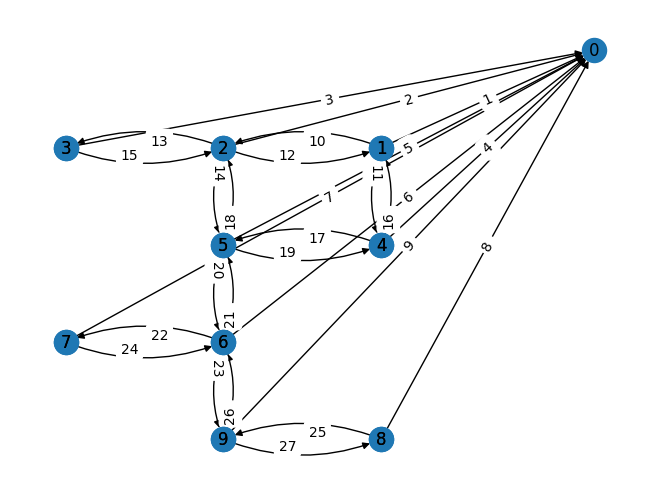

In [29]:
py"""
def complete_Graph (network,pos):
    # Draw the Directed Graph
    
    G = nx.DiGraph()
    G = nx.from_numpy_array(network,create_using=nx.DiGraph(directed=True))
    
    ##
    
    network_0 = network.copy()
    network_0[1:,1:] = 0
    
    G_0 = nx.DiGraph()
    G_0 = nx.from_numpy_array(network_0,create_using=nx.DiGraph(directed=True))
      
    nx.draw(G_0,pos,with_labels=True)
    
    edge_label = {}
    for j, edge in enumerate(G_0.edges()):
        edge_label.update({(edge[0],edge[1]): str(j + 1)})
        
    graph = nx.draw_networkx_edge_labels(G_0,pos,edge_labels = edge_label)
    
    ##
    
    G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)
    
    ##
    edge_label.update(sub_edge_label)
    graph.update(sub_graph)
    
    return G, edge_label, graph

def sub_Graph (network,pos):
    G_prime = nx.DiGraph()
    G_prime = nx.from_numpy_array(network,create_using=nx.DiGraph(directed=True))
    G_prime.remove_node(0)
    
    
    # Label Edge with following rules:
    # 1. num(BUS)<num(branch)
    # 2. priority(BUS)>priority(branch)
    sub_edge_label = {}
    sub_edge_label_up = {}
    sub_edge_label_down = {}
    sub_edge_label_initial = {}
    
    for j, edge in enumerate(G_prime.edges()):
        if edge[1] > edge[0]:
            sub_edge_label_up.update({(edge[0],edge[1]): str(j+len(pos))})
        else:
            sub_edge_label_down.update({(edge[0],edge[1]): str(j+len(pos))})
        
    
    nx.draw(G_prime,pos,with_labels=True,connectionstyle='arc3, rad = 0.2')
    
    
    sub_edge_label.update(sub_edge_label_initial)
    sub_edge_label.update(sub_edge_label_up)
    sub_edge_label.update(sub_edge_label_down)
    
    sub_graph_initial = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_initial)
    sub_graph_up = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_up, label_pos = 0.65, verticalalignment = 'bottom',horizontalalignment = 'right')
    sub_graph_down = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_down, label_pos = 0.65, verticalalignment = 'top',horizontalalignment = 'left')

    sub_graph = {}
    sub_graph.update(sub_graph_initial)
    sub_graph.update(sub_graph_up)
    sub_graph.update(sub_graph_down)
    
    return G_prime, sub_edge_label, sub_graph

"""
G, compelete_label, graph = py"complete_Graph"(complete_network,pos);


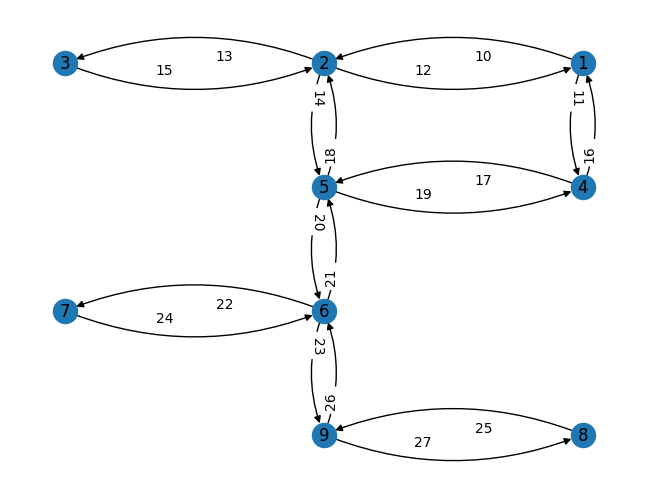

In [30]:
G_prime, sub_edge_label = py"sub_Graph"(complete_network,pos);

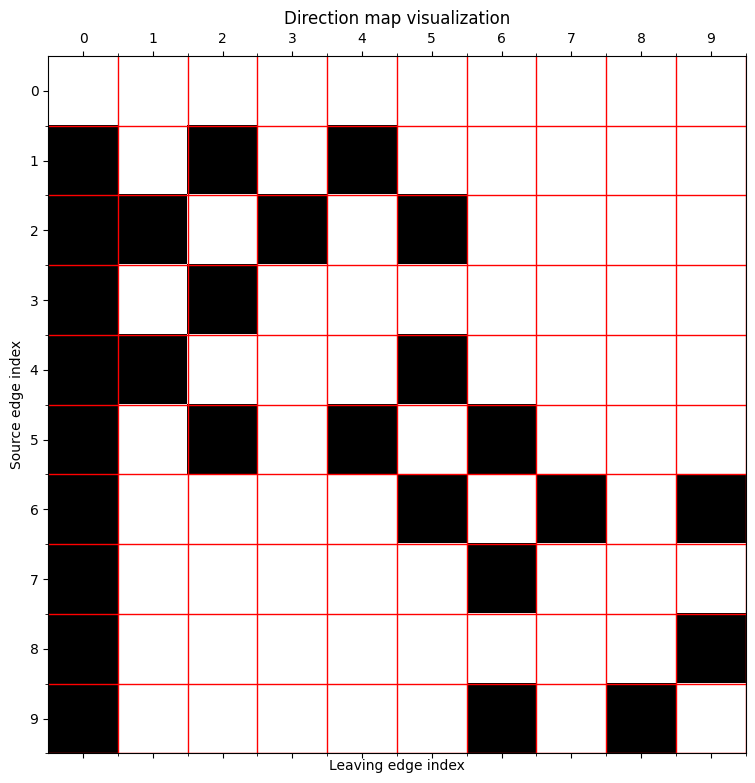

C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\src\pyeval.jl:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # and a current "file name" to use for stack traces


In [31]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def edge_map (network):
    matfig = plt.figure(figsize=(9,9))
    plt.matshow(network,cmap=plt.cm.binary,fignum=matfig.number)
    ax = plt.gca()
    #plt.matshow(Final_map,cmap=plt.cm.binary)
    plt.xlabel('Leaving edge index')
    plt.ylabel('Source edge index')
    plt.title ("Direction map visualization")

    # Major ticks
    ax.set_xticks(np.arange(0, network.shape[0], step=1))
    ax.set_yticks(np.arange(0, network.shape[0], step=1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, network.shape[0], step=1))
    ax.set_yticklabels(np.arange(0, network.shape[0], step=1))

    # Minor ticks
    ax.set_xticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)
    ax.set_yticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)

    plt.show()
"""
py"edge_map"(complete_network);

In [32]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

def Draw_edge_map (Final_map, lowest_edge_number,compelete_label,pos,G):
    matfig = plt.figure(figsize=(9,9))
    plt.matshow(Final_map,cmap=plt.cm.binary,fignum=matfig.number)
    ax = plt.gca()
    #plt.matshow(Final_map,cmap=plt.cm.binary)
    plt.xlabel('Leaving edge index')
    plt.ylabel('Source edge index')
    plt.title ("Direction map visualization")

    # Major ticks
    ax.set_xticks(np.arange(0, Final_map.shape[0], step=1))
    ax.set_yticks(np.arange(0, Final_map.shape[0], step=1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, Final_map.shape[0]+1, step=1))
    ax.set_yticklabels(np.arange(1, Final_map.shape[0]+1, step=1))

    # Minor ticks
    ax.set_xticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)
    ax.set_yticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)
    
    

"""
#py"Draw_edge_map"(Final_map, lowest_edge_number,compelete_label,pos,G)


# Quick note of plt.show() is kind of deprecated.
# .julia\packages\PyCall\tqyST\src\pyeval.jl:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
# @pycheckn ccall((@pysym :PyEval_EvalCode),

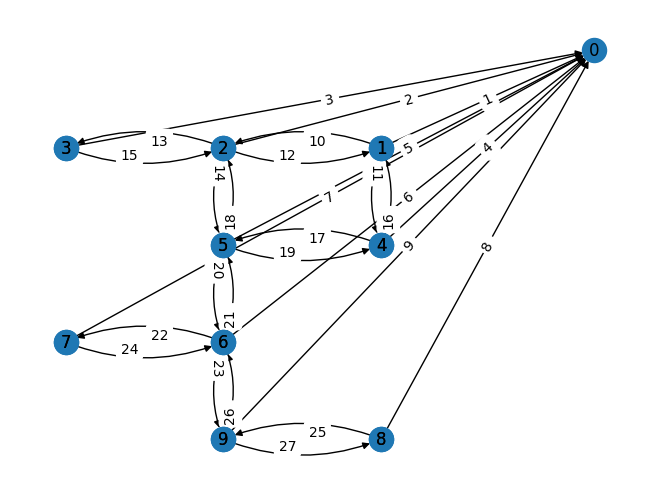

In [33]:
py"complete_Graph"(complete_network,pos);

In [34]:
1:size(complete_network)[1]

1:10

In [35]:
edge_total = length(compelete_label)

27

In [36]:
compelete_label

Dict{Any,Any} with 27 entries:
  (2, 3) => "13"
  (3, 0) => "3"
  (6, 9) => "23"
  (5, 6) => "20"
  (5, 0) => "5"
  (5, 4) => "19"
  (8, 9) => "25"
  (2, 1) => "12"
  (2, 5) => "14"
  (1, 0) => "1"
  (2, 0) => "2"
  (1, 4) => "11"
  (7, 0) => "7"
  (4, 5) => "17"
  (4, 0) => "4"
  (3, 2) => "15"
  (5, 2) => "18"
  (7, 6) => "24"
  (6, 7) => "22"
  (6, 5) => "21"
  (9, 0) => "9"
  (8, 0) => "8"
  (1, 2) => "10"
  (6, 0) => "6"
  (4, 1) => "16"
  ⋮      => ⋮

In [37]:
iout_map = [ findall( x ->  x > 0, complete_network[ie,:]) for ie in 1:size(complete_network)[1]]
iin_map = [ findall( x ->  x > 0, complete_network[:,ie]) for ie in 1:size(complete_network)[1]]

println(iout_map)
println(iin_map)

[[], [1, 3, 5], [1, 2, 4, 6], [1, 3], [1, 2, 6], [1, 3, 5, 7], [1, 6, 8, 10], [1, 7], [1, 10], [1, 7, 9]]
[[2, 3, 4, 5, 6, 7, 8, 9, 10], [3, 5], [2, 4, 6], [3], [2, 6], [3, 5, 7], [6, 8, 10], [7], [10], [7, 9]]


In [38]:
for i = 1: size(complete_network)[1]
    for to_vertex in iout_map[i]
        print((i-1,to_vertex - 1))
        a = compelete_label[(i-1,to_vertex - 1)]
        print(a)
        print(typeof(parse(Int64, a)))
        println( typeof( a ) )
        
    end
end

(1, 0)1Int64String
(1, 2)10Int64String
(1, 4)11Int64String
(2, 0)2Int64String
(2, 1)12Int64String
(2, 3)13Int64String
(2, 5)14Int64String
(3, 0)3Int64String
(3, 2)15Int64String
(4, 0)4Int64String
(4, 1)16Int64String
(4, 5)17Int64String
(5, 0)5Int64String
(5, 2)18Int64String
(5, 4)19Int64String
(5, 6)20Int64String
(6, 0)6Int64String
(6, 5)21Int64String
(6, 7)22Int64String
(6, 9)23Int64String
(7, 0)7Int64String
(7, 6)24Int64String
(8, 0)8Int64String
(8, 9)25Int64String
(9, 0)9Int64String
(9, 6)26Int64String
(9, 8)27Int64String


In [39]:
x = zeros(0)
append!( x, rand(10) )


10-element Array{Float64,1}:
 0.8365941573585505
 0.8239284109318146
 0.0250689056635367
 0.8532800483064329
 0.08505929326734041
 0.887607484740988
 0.2761534591488817
 0.44171201710548913
 0.7025087530978005
 0.08466997545821964

In [40]:
Q = size(complete_network)[1]
c_e = 1
p =1
println(Q)
typeof(Q)

10


Int64

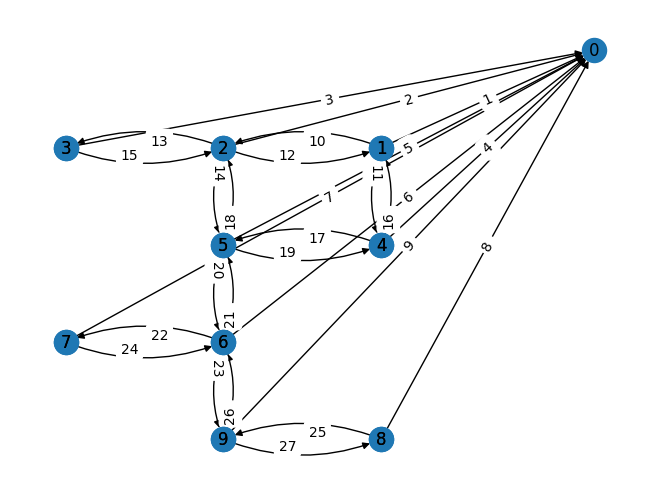

(PyObject <networkx.classes.digraph.DiGraph object at 0x00000000427D6D60>, Dict{Any,Any}((2, 3) => "13",(3, 0) => "3",(6, 9) => "23",(5, 6) => "20",(5, 0) => "5",(5, 4) => "19",(8, 9) => "25",(2, 1) => "12",(2, 5) => "14",(1, 0) => "1"…), Dict{Any,Any}((2, 3) => PyObject Text(1.3, 6.0, '13'),(3, 0) => PyObject Text(3.35, 7.0, '3'),(6, 9) => PyObject Text(2.0, 1.3, '23'),(5, 6) => PyObject Text(2.0, 3.3, '20'),(5, 0) => PyObject Text(4.35, 6.0, '5'),(5, 4) => PyObject Text(2.7, 4.0, '19'),(8, 9) => PyObject Text(3.3, 0.0, '25'),(2, 1) => PyObject Text(2.7, 6.0, '12'),(2, 5) => PyObject Text(2.0, 5.300000000000001, '14'),(1, 0) => PyObject Text(5.35, 7.0, '1')…))

In [41]:

py"complete_Graph"(complete_network,pos)

In [42]:
m_l = zeros(1,Q)
m_u = 3 * ones(1,Q)
m_u[1:3] .= 0
println(m_u)

[0.0 0.0 0.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0]


In [43]:
#def Location_Solver (edge_total, Q, m_l, m_u, compelete_label, iin_map, iout_map)
    

#end

In [47]:


println(iout_map)
println(iin_map)
model = Model(with_optimizer(GLPK.Optimizer))
@variable(model, x[1:edge_total, 1 : Q], Bin)
    
@objective(model, Min, 
        sum(
            sum(
                c_e * x[ie,id]
            for ie = 1: edge_total)
        for id = 1: Q)
        +
        p*sum(
            sum(
                (id-1) * c_e * x[ie,id]
            for ie = Q + 1 : edge_total)
        for id = 1: Q)
        )

@constraint(model,c1[ie in 2:Q], sum(sum(  x[  parse(Int64, compelete_label[(ie - 1, iout - 1 )] ) , id ]  for id =1 : Q) for iout in iout_map[ie]) == 1)
@constraint(model,c2[ie in 2:Q], (sum(sum(id * x[parse(Int64, compelete_label[(ie - 1, iout - 1 )] ) , id] for id =1 : Q) for iout in iout_map[ie]) - sum(sum(id * x[parse(Int64, compelete_label[(iin - 1 , ie - 1 )] ), id] for id =1 :Q) for iin in iin_map[ie])) == 1)
@constraint(model,c3[id in 1:Q], m_l[id] <= sum( x[ie , id] for ie in 1:Q ) <= m_u[id] )

#@constraint(model, c2, 7x + 12y >= 120)
print(model)

optimize!(model)
@show termination_status(model)

@show objective_value(model)



[[], [1, 3, 5], [1, 2, 4, 6], [1, 3], [1, 2, 6], [1, 3, 5, 7], [1, 6, 8, 10], [1, 7], [1, 10], [1, 7, 9]]
[[2, 3, 4, 5, 6, 7, 8, 9, 10], [3, 5], [2, 4, 6], [3], [2, 6], [3, 5, 7], [6, 8, 10], [7], [10], [7, 9]]
Min x[1,1] + x[2,1] + x[3,1] + x[4,1] + x[5,1] + x[6,1] + x[7,1] + x[8,1] + x[9,1] + x[10,1] + x[11,1] + x[12,1] + x[13,1] + x[14,1] + x[15,1] + x[16,1] + x[17,1] + x[18,1] + x[19,1] + x[20,1] + x[21,1] + x[22,1] + x[23,1] + x[24,1] + x[25,1] + x[26,1] + x[27,1] + x[1,2] + x[2,2] + x[3,2] + x[4,2] + x[5,2] + x[6,2] + x[7,2] + x[8,2] + x[9,2] + x[10,2] + 2 x[11,2] + 2 x[12,2] + 2 x[13,2] + 2 x[14,2] + 2 x[15,2] + 2 x[16,2] + 2 x[17,2] + 2 x[18,2] + 2 x[19,2] + 2 x[20,2] + 2 x[21,2] + 2 x[22,2] + 2 x[23,2] + 2 x[24,2] + 2 x[25,2] + 2 x[26,2] + 2 x[27,2] + x[1,3] + x[2,3] + x[3,3] + x[4,3] + x[5,3] + x[6,3] + x[7,3] + x[8,3] + x[9,3] + x[10,3] + 3 x[11,3] + 3 x[12,3] + 3 x[13,3] + 3 x[14,3] + 3 x[15,3] + 3 x[16,3] + 3 x[17,3] + 3 x[18,3] + 3 x[19,3] + 3 x[20,3] + 3 x[21,3] + 3 x[22

termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 11.0


11.0

In [48]:
time(x) =@time optimize!(model)

print(time(x))

  0.030618 seconds (3.55 k allocations: 229.797 KiB)
nothing

In [419]:
@show JuMP.value.(x)
answer = JuMP.value.(x)

JuMP.value.(x) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

29×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

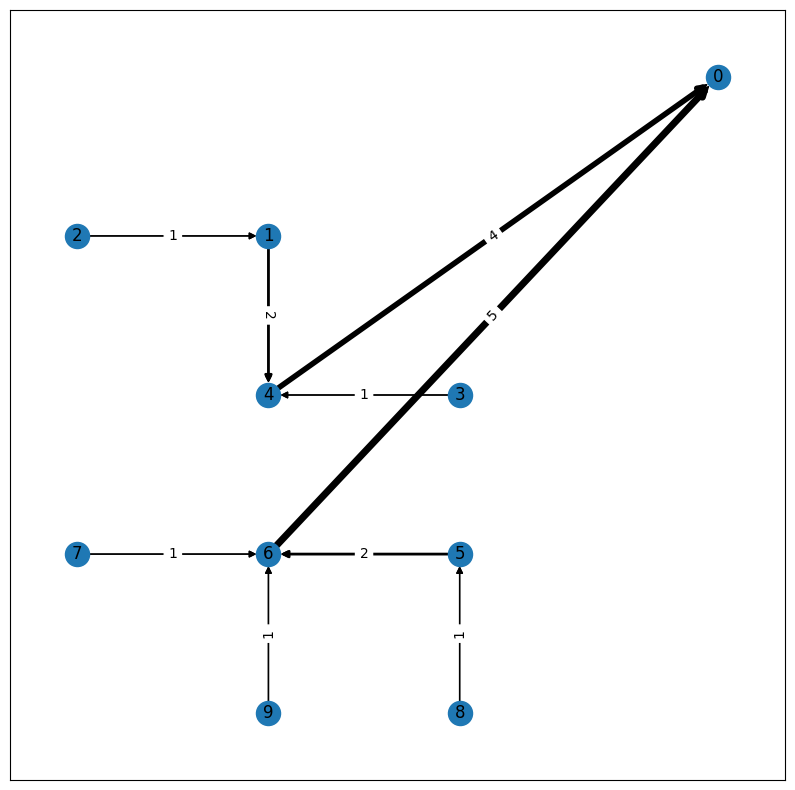

29 10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 34  55 102 111 121 182 241 251 271]
3
5
10
11
12
18
24
25
27


In [420]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def show_answer(answer,pos,compelete_label,network):
    edge_num , Q = np.shape(answer) 
    print(edge_num , Q)
    result = answer.flatten()
    print(result)
    temp =np.where(result > 0)[0]
    final_index = temp.astype(int) + 1
    print(final_index)
    
    final_G = nx.DiGraph()
    final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

    for value in final_index:
        print(str(value//Q))
        final_G.add_weighted_edges_from([(*edge, value % Q) for edge, label in compelete_label.items() if label == str(value//Q + 1)])

    matfig = plt.figure(figsize=(10,10)) 
    labels = nx.get_edge_attributes(final_G,'weight')
    widths = list(nx.get_edge_attributes(final_G,'weight').values())
    a = nx.draw_networkx(final_G, pos)
    b = nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
    c = nx.draw_networkx_edges(final_G,pos,width = widths)


"""
py"show_answer"(answer,pos,compelete_label,complete_network)

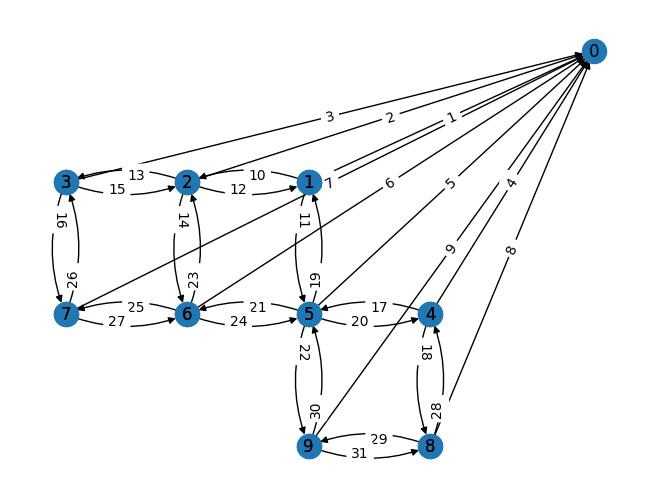

In [362]:
py"complete_Graph"(complete_network,pos);

termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 6.0
JuMP.value.(x) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


18×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [188]:
# 需要改的部分
#1、 Python 生成的边图应该保持方向性，虽然这样会double 边的数量
#2、注意 原论文公式2，3  i应该只覆盖比lowest_edge_number的edge的编号（白话说就是只统计双向边的进出流量） 
#3、应增添每个顶点的进出edge 的黑白图